# 02. 에란겔 클러스터링 — UMAP + HDBSCAN

## 분석 흐름
```
피처 테이블 로드
  → 결측치 처리 + 이상치 제거
  → StandardScaler 정규화
  → UMAP 차원 축소 (8차원 → 2차원)
  → HDBSCAN 클러스터링
  → 클러스터별 피처 프로파일 해석
  → 모델 저장
```

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import umap
from sklearn.cluster import HDBSCAN          # sklearn 1.3+ 내장
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

BASE_DIR   = r'C:\배그분석'
OUTPUT_DIR = os.path.join(BASE_DIR, 'analysis_output')
MODEL_DIR  = os.path.join(OUTPUT_DIR, 'models')
os.makedirs(MODEL_DIR, exist_ok=True)

print('설정 완료')

설정 완료


In [2]:
# STEP 1: 피처 테이블 로드
df = pd.read_parquet(os.path.join(OUTPUT_DIR, 'erangel_features.parquet'))
print(f'로드 완료: {df.shape[0]:,}행 × {df.shape[1]}열')
display(df.head(3))

로드 완료: 147,673행 × 25열


,matchId,accountId,rotation_timing_score,vehicle_use_ratio,bluezone_exposure_ratio,safezone_proximity_mean,safezone_edge_ratio,altitude_variance,survival_time,total_movement,...,kills,damageDealt,winPlace,win_flag,top10_flag,timeSurvived,walkDistance,rideDistance,heals,boosts
0,001491cf-ad60-4ebc-b6a1-c86bc05959fd,account.00ae636f3f29443490716d28017686d2,0.635235,0.172414,0.126437,117728.696332,0.687277,1430.389772,1719.0,6.582388e+05,...,3.0,249.50539,2.0,0.0,1.0,1766.0,4123.179,4482.5470,4.0,6.0
1,001491cf-ad60-4ebc-b6a1-c86bc05959fd,account.04550355e52549ea99457094928c0316,0.556537,0.147826,0.052174,148634.388292,0.603394,21271.393148,1304.0,9.153429e+05,...,0.0,0.00000,4.0,0.0,1.0,1176.0,2180.932,5912.9204,1.0,5.0
2,001491cf-ad60-4ebc-b6a1-c86bc05959fd,account.09c7523488a6456abbee4404309fa9b4,0.695087,0.491525,0.000000,78212.402345,0.409086,12176.072837,1288.0,1.220069e+06,...,1.0,329.19660,5.0,0.0,1.0,1198.0,1521.188,10001.2380,2.0,6.0


In [3]:
# STEP 2: 클러스터링에 사용할 피처 선택
FEATURE_COLS = [
    'drop_distance_from_path',   # 낙하 거리 (외곽 vs 중앙)
    'early_enemy_density',       # 초기 적 밀도 (핫드랍 성향)
    'rotation_timing_score',     # 로테이션 타이밍 (선점 vs 후행)
    'vehicle_use_ratio',         # 차량 의존도
    'bluezone_exposure_ratio',   # 존타기 성향
    'safezone_proximity_mean',   # 안전구역 거리 (알박기 vs 외곽)
    'safezone_edge_ratio',       # 상대적 외곽 포지셔닝
    'altitude_variance',         # 지형 고도 활용도
]

# 결측치가 너무 많은 행 제거 (피처의 50% 이상 결측)
df_clean = df.dropna(subset=FEATURE_COLS, thresh=int(len(FEATURE_COLS)*0.5)).copy()
print(f'결측치 제거 후: {len(df_clean):,}행 ({len(df_clean)/len(df):.1%} 유지)')

# 생존 시간 최소 2분 이상만 (너무 일찍 죽은 경우 제외)
df_clean = df_clean[df_clean['survival_time'] >= 120].copy()
print(f'생존 2분 이상 필터: {len(df_clean):,}행')

결측치 제거 후: 147,673행 (100.0% 유지)
생존 2분 이상 필터: 134,392행


In [4]:
# STEP 3: 이상치 제거 (IQR 방식)
def remove_outliers_iqr(df, cols, k=3.0):
    mask = pd.Series([True]*len(df), index=df.index)
    for col in cols:
        q1, q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        iqr = q3 - q1
        mask &= (df[col] >= q1 - k*iqr) & (df[col] <= q3 + k*iqr)
    return df[mask]

cols_for_outlier = ['drop_distance_from_path', 'safezone_proximity_mean', 'altitude_variance']
df_clean = remove_outliers_iqr(df_clean, 
    [c for c in cols_for_outlier if c in df_clean.columns])
print(f'이상치 제거 후: {len(df_clean):,}행')

# 피처 행렬 추출
X_raw = df_clean[FEATURE_COLS].values

이상치 제거 후: 116,462행


In [5]:
# STEP 4: 전처리: 결측치 보간 + 정규화
# 결측치 → 중앙값으로 대체
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_raw)

# StandardScaler 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

print(f'전처리 완료: {X_scaled.shape}')
print('피처별 통계 (정규화 전):')
display(pd.DataFrame(X_imputed, columns=FEATURE_COLS).describe().round(3))

전처리 완료: (116462, 8)
피처별 통계 (정규화 전):


,drop_distance_from_path,early_enemy_density,rotation_timing_score,vehicle_use_ratio,bluezone_exposure_ratio,safezone_proximity_mean,safezone_edge_ratio,altitude_variance
count,116462.000,116462.000,116462.000,116462.000,116462.000,116462.000,116462.000,116462.000
mean,79109.027,2.996,0.547,0.154,0.057,147970.888,0.608,1491.849
std,47674.053,4.436,0.072,0.148,0.109,75341.263,25.016,1599.390
min,1.558,0.000,0.071,0.000,0.000,6165.113,0.011,0.000
25%,38608.704,0.000,0.503,0.000,0.000,88416.381,0.346,428.382
50%,77659.487,0.000,0.543,0.141,0.000,130309.147,0.467,1066.301
75%,116868.457,4.000,0.591,0.257,0.063,200368.269,0.586,1871.498
max,266045.071,39.000,0.900,0.960,1.000,507870.256,7232.520,9408.987


In [6]:
# STEP 5: UMAP 차원 축소
# n_components=2: 시각화용
# n_neighbors=30: 지역 구조 vs 전역 구조 밸런스
# min_dist=0.1: 클러스터 내부 밀도

print('UMAP 차원 축소 중... (수분 소요 가능)')

reducer = umap.UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.1,
    metric='euclidean',
    random_state=42,
    verbose=True
)
embedding = reducer.fit_transform(X_scaled)

print(f'UMAP 완료: {embedding.shape}')

UMAP 차원 축소 중... (수분 소요 가능)
UMAP(n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Mon Feb 23 23:18:53 2026 Construct fuzzy simplicial set
Mon Feb 23 23:18:53 2026 Finding Nearest Neighbors
Mon Feb 23 23:18:53 2026 Building RP forest with 22 trees
Mon Feb 23 23:18:56 2026 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	Stopping threshold met -- exiting after 2 iterations
Mon Feb 23 23:19:08 2026 Finished Nearest Neighbor Search
Mon Feb 23 23:19:09 2026 Construct embedding


Epochs completed:   2%| ▏          3/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  11%| █          22/200 [00:04]

	completed  20  /  200 epochs


Epochs completed:  20%| ██         41/200 [00:08]

	completed  40  /  200 epochs


Epochs completed:  31%| ███        62/200 [00:12]

	completed  60  /  200 epochs


Epochs completed:  40%| ████       81/200 [00:16]

	completed  80  /  200 epochs


Epochs completed:  50%| █████      101/200 [00:20]

	completed  100  /  200 epochs


Epochs completed:  60%| ██████     121/200 [00:24]

	completed  120  /  200 epochs


Epochs completed:  71%| ███████    142/200 [00:29]

	completed  140  /  200 epochs


Epochs completed:  80%| ████████   161/200 [00:33]

	completed  160  /  200 epochs


Epochs completed:  91%| █████████  182/200 [00:37]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:41]

Mon Feb 23 23:19:56 2026 Finished embedding
UMAP 완료: (116462, 2)


In [7]:
# STEP 6: HDBSCAN 클러스터링 (sklearn 내장)
# min_cluster_size: 최소 클러스터 크기 (전체의 ~2%)
# min_samples: 핵심 포인트 조건
# store_centers: 새 데이터 예측을 위한 클러스터 중심 저장

n_total = len(df_clean)
min_cs = max(50, int(n_total * 0.02))

print(f'HDBSCAN 실행 중... (min_cluster_size={min_cs})')

clusterer = HDBSCAN(
    min_cluster_size=min_cs,
    min_samples=10,
    cluster_selection_method='eom',
    store_centers='centroid',   # sklearn 방식: 중심 저장
    copy=True
)
labels = clusterer.fit_predict(embedding)

# 결과 요약
unique_labels = sorted(set(labels))
n_clusters = len([l for l in unique_labels if l >= 0])
n_noise = (labels == -1).sum()

print(f'\n클러스터 수: {n_clusters}')
print(f'노이즈 포인트: {n_noise:,} ({n_noise/n_total:.1%})')
print()
for lbl in unique_labels:
    cnt = (labels == lbl).sum()
    name = '노이즈' if lbl == -1 else f'C{lbl}'
    print(f'  {name}: {cnt:,}명 ({cnt/n_total:.1%})')


HDBSCAN 실행 중... (min_cluster_size=2329)

클러스터 수: 3
노이즈 포인트: 1,311 (1.1%)

  노이즈: 1,311명 (1.1%)
  C0: 7,817명 (6.7%)
  C1: 95,711명 (82.2%)
  C2: 11,623명 (10.0%)


In [8]:
# STEP 7: 클러스터 레이블을 데이터에 추가
df_clean = df_clean.copy()
df_clean['cluster'] = labels
df_clean['umap_x']  = embedding[:, 0]
df_clean['umap_y']  = embedding[:, 1]

# 클러스터별 피처 프로파일
profile = df_clean[df_clean['cluster'] >= 0].groupby('cluster')[FEATURE_COLS].median().round(3)
print('클러스터별 피처 중앙값:')
display(profile)

클러스터별 피처 중앙값:


,drop_distance_from_path,early_enemy_density,rotation_timing_score,vehicle_use_ratio,bluezone_exposure_ratio,safezone_proximity_mean,safezone_edge_ratio,altitude_variance
cluster,,,,,,,,
0,59412.000,9.0,0.508,0.000,0.0,231902.400,0.414,168.900
1,80187.661,0.0,0.550,0.182,0.0,115721.029,0.475,1253.421
2,75345.780,4.0,0.519,0.000,0.0,237554.844,0.454,327.895


In [9]:
# STEP 8: 클러스터 이름 자동 배정
# 피처 프로파일 기반으로 페르소나 이름 결정

def assign_cluster_name(row):
    """피처 중앙값 기준으로 클러스터 페르소나 이름 배정"""
    drop_dist  = row.get('drop_distance_from_path', 0)
    density    = row.get('early_enemy_density', 0)
    rotation   = row.get('rotation_timing_score', 0.5)
    vehicle    = row.get('vehicle_use_ratio', 0)
    bluezone   = row.get('bluezone_exposure_ratio', 0)
    safe_prox  = row.get('safezone_proximity_mean', 0)
    edge_ratio = row.get('safezone_edge_ratio', 0)
    
    # 피처 상대값 (전체 중앙값과 비교)
    scores = {
        'C0_center': (
            (drop_dist < profile['drop_distance_from_path'].median()) +   # 중앙 낙하
            (density > profile['early_enemy_density'].median()) +          # 핫드랍
            (rotation < 0.5) +                                             # 선점
            (vehicle > profile['vehicle_use_ratio'].median())              # 차량 사용
        ),
        'C1_edge': (
            (drop_dist > profile['drop_distance_from_path'].median()) +   # 외곽 낙하
            (density < profile['early_enemy_density'].median()) +          # 저밀도
            (edge_ratio > profile['safezone_edge_ratio'].median())        # 외곽 포지션
        ),
        'C2_aggro': (
            (density > profile['early_enemy_density'].quantile(0.75)) +   # 매우 높은 밀도
            (bluezone < profile['bluezone_exposure_ratio'].median())       # 존 안 탐
        ),
        'C3_guerilla': (
            (vehicle < profile['vehicle_use_ratio'].median()) +            # 차량 비선호
            (bluezone > profile['bluezone_exposure_ratio'].median()) +     # 존 탐
            (rotation > 0.6)                                               # 후행
        ),
    }
    return max(scores, key=scores.get)

cluster_names = {}
for cluster_id in profile.index:
    cluster_names[cluster_id] = assign_cluster_name(profile.loc[cluster_id])
cluster_names[-1] = 'noise'

PERSONA_LABELS = {
    'C0_center':   '🏃 중앙 점령형',
    'C1_edge':     '🌿 외곽 운영형',
    'C2_aggro':    '⚔️  하이리스크 어태커',
    'C3_guerilla': '🦅 게릴라 운영형',
    'noise':       '⬛ 노이즈',
}

df_clean['persona'] = df_clean['cluster'].map(cluster_names).map(PERSONA_LABELS)

print('클러스터 → 페르소나 매핑:')
for k,v in cluster_names.items():
    cnt = (df_clean['cluster']==k).sum()
    print(f'  Cluster {k:2d} → {PERSONA_LABELS.get(v,v)}: {cnt:,}명')

클러스터 → 페르소나 매핑:
  Cluster  0 → 🏃 중앙 점령형: 7,817명
  Cluster  1 → 🏃 중앙 점령형: 95,711명
  Cluster  2 → 🏃 중앙 점령형: 11,623명
  Cluster -1 → ⬛ 노이즈: 1,311명


In [10]:
# STEP 9: 클러스터별 승률 분석

result_cols = ['cluster','persona','win_flag','top10_flag','kills','damageDealt','winPlace']
existing = [c for c in result_cols if c in df_clean.columns]

cluster_results = df_clean[df_clean['cluster'] >= 0].groupby(['cluster','persona']).agg(
    n_players=('win_flag','count'),
    win_rate=('win_flag','mean'),
    top10_rate=('top10_flag','mean'),
    avg_kills=('kills','mean'),
    avg_damage=('damageDealt','mean'),
    avg_winplace=('winPlace','mean'),
).round(3).reset_index()

print('클러스터별 게임 결과:')
display(cluster_results.sort_values('win_rate', ascending=False))

클러스터별 게임 결과:


,cluster,persona,n_players,win_rate,top10_rate,avg_kills,avg_damage,avg_winplace
1,1,🏃 중앙 점령형,90533,0.078,0.679,1.239,215.863,8.124
2,2,🏃 중앙 점령형,9041,0.003,0.083,0.290,82.996,14.505
0,0,🏃 중앙 점령형,7429,0.002,0.065,0.708,127.003,15.564


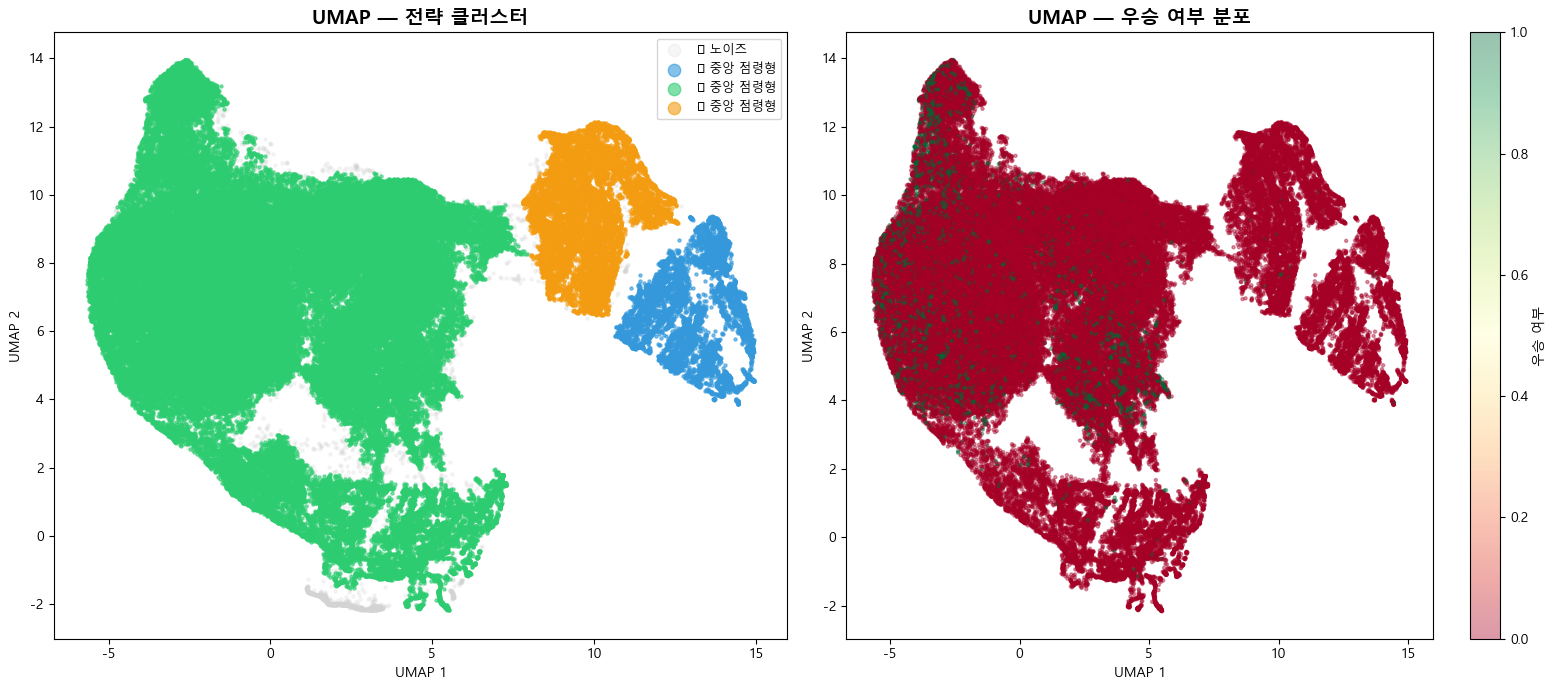

저장 완료: umap_clusters.png


In [11]:
# STEP 10: UMAP 산점도 시각화

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

colors = ['#E74C3C','#3498DB','#2ECC71','#F39C12','#9B59B6','#1ABC9C','#E67E22','gray']

# 왼쪽: 클러스터 색상
ax = axes[0]
unique_c = sorted(df_clean['cluster'].unique())
for i, c in enumerate(unique_c):
    mask = df_clean['cluster'] == c
    label = cluster_names.get(c, f'C{c}')
    persona = PERSONA_LABELS.get(label, label)
    color = 'lightgray' if c == -1 else colors[i % len(colors)]
    alpha = 0.2 if c == -1 else 0.6
    ax.scatter(
        df_clean.loc[mask, 'umap_x'],
        df_clean.loc[mask, 'umap_y'],
        c=color, alpha=alpha, s=5, label=persona
    )
ax.set_title('UMAP — 전략 클러스터', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', markerscale=4, fontsize=9)
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

# 오른쪽: 승률 히트맵
ax2 = axes[1]
non_noise = df_clean[df_clean['cluster'] >= 0]
sc = ax2.scatter(
    non_noise['umap_x'], non_noise['umap_y'],
    c=non_noise['win_flag'], cmap='RdYlGn',
    alpha=0.4, s=5, vmin=0, vmax=1
)
plt.colorbar(sc, ax=ax2, label='우승 여부')
ax2.set_title('UMAP — 우승 여부 분포', fontsize=14, fontweight='bold')
ax2.set_xlabel('UMAP 1')
ax2.set_ylabel('UMAP 2')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'umap_clusters.png'), dpi=150, bbox_inches='tight')
plt.show()
print('저장 완료: umap_clusters.png')

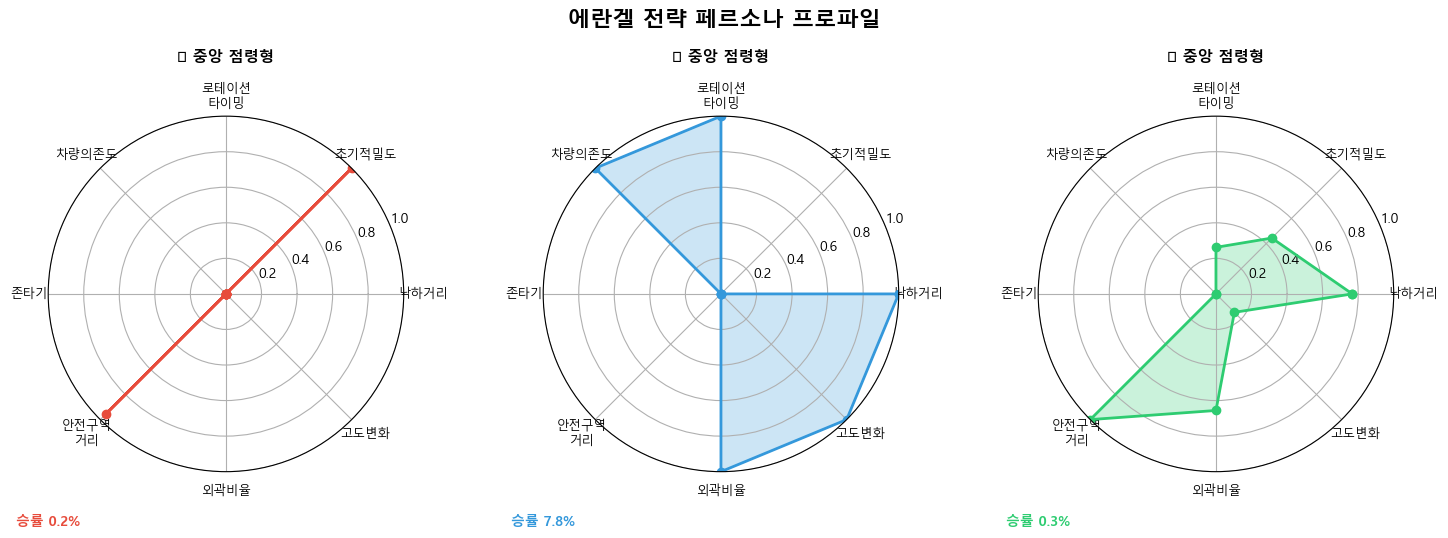

저장 완료: cluster_radar.png


In [12]:
# STEP 11: 레이더 차트 — 클러스터 프로파일

from matplotlib.patches import FancyArrowPatch
import matplotlib.patheffects as pe

# 0~1 정규화된 피처 프로파일
profile_norm = (profile - profile.min()) / (profile.max() - profile.min() + 1e-6)

feature_labels = [
    '낙하거리', '초기적밀도', '로테이션\n타이밍', '차량의존도',
    '존타기', '안전구역\n거리', '외곽비율', '고도변화'
]
N = len(FEATURE_COLS)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]

fig, axes = plt.subplots(1, n_clusters, figsize=(5*n_clusters, 5), 
                          subplot_kw={'polar': True})
if n_clusters == 1:
    axes = [axes]

for idx, (cluster_id, row) in enumerate(profile_norm.iterrows()):
    ax = axes[idx]
    vals = row.tolist() + row.tolist()[:1]
    color = colors[idx % len(colors)]
    persona_name = PERSONA_LABELS.get(cluster_names.get(cluster_id, ''), f'C{cluster_id}')
    
    ax.plot(angles, vals, 'o-', linewidth=2, color=color)
    ax.fill(angles, vals, alpha=0.25, color=color)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(feature_labels, fontsize=9)
    ax.set_ylim(0, 1)
    ax.set_title(persona_name, fontsize=11, fontweight='bold', pad=15)
    
    # 승률 표시
    wr = cluster_results[cluster_results['cluster']==cluster_id]['win_rate'].values
    if len(wr) > 0:
        ax.text(0, -0.15, f'승률 {wr[0]:.1%}', transform=ax.transAxes,
                ha='center', fontsize=10, color=color, fontweight='bold')

plt.suptitle('에란겔 전략 페르소나 프로파일', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'cluster_radar.png'), dpi=150, bbox_inches='tight')
plt.show()
print('저장 완료: cluster_radar.png')

In [13]:
# STEP 12: 모델 및 결과 저장

# 모델 저장 (타 맵 적용 시 사용)
model_bundle = {
    'reducer': reducer,
    'clusterer': clusterer,
    'scaler': scaler,
    'imputer': imputer,
    'feature_cols': FEATURE_COLS,
    'cluster_names': cluster_names,
    'persona_labels': PERSONA_LABELS,
    'profile': profile,
}

with open(os.path.join(MODEL_DIR, 'erangel_model.pkl'), 'wb') as f:
    pickle.dump(model_bundle, f)

# 클러스터 라벨 포함 데이터 저장
df_clean.to_parquet(os.path.join(OUTPUT_DIR, 'erangel_clustered.parquet'), index=False)

print('저장 완료!')
print(f'  모델: {MODEL_DIR}/erangel_model.pkl')
print(f'  데이터: {OUTPUT_DIR}/erangel_clustered.parquet')
print()
print('03_apply_maps.ipynb 로 이동')

Mon Feb 23 23:21:01 2026 Building hub-based search tree
Mon Feb 23 23:21:05 2026 Forward diversification reduced edges from 3493860 to 785059
Mon Feb 23 23:21:06 2026 Reverse diversification reduced edges from 785059 to 785059
Mon Feb 23 23:21:08 2026 Degree pruning reduced edges from 839098 to 839098
Mon Feb 23 23:21:08 2026 Resorting data and graph based on tree order
Mon Feb 23 23:21:08 2026 Building and compiling search function
저장 완료!
  모델: C:\배그분석\analysis_output\models/erangel_model.pkl
  데이터: C:\배그분석\analysis_output/erangel_clustered.parquet

03_apply_maps.ipynb 로 이동
